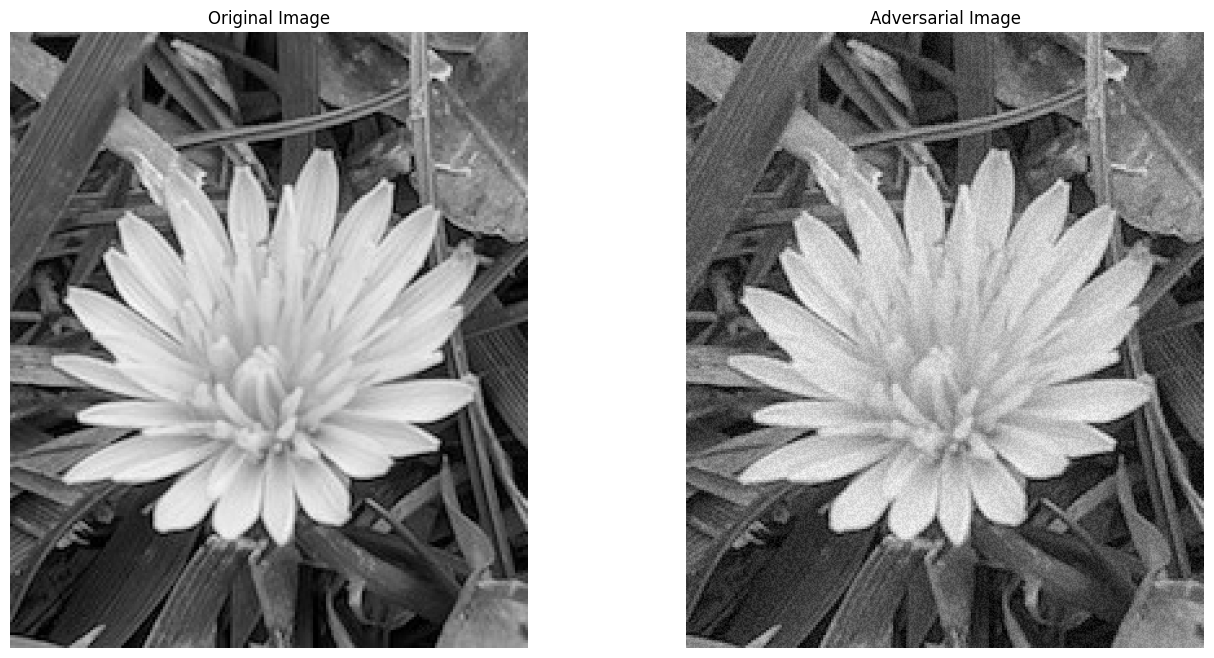

In [19]:
# ---------------------- Adversarial Image Generation: FGSM ----------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load original image
image = cv2.imread('flower.png', cv2.IMREAD_GRAYSCALE)
# Create noise
noise = np.random.normal(0, 25, image.shape).astype('uint8')
# Add noise to create adversarial image
adversarial_image = cv2.addWeighted(image, 1.0, noise, 0.1, 0)

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 8))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot adversarial image
plt.subplot(1, 2, 2)
plt.imshow(adversarial_image, cmap='gray')
plt.title('Adversarial Image')
plt.axis('off')

plt.show()

In [63]:
# ------------------------------------------------- GAN ------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
batch_size = 32
num_epochs = 10
lr = 0.0001
beta1 = 0.5

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Network
generator = nn.Sequential(
    nn.Linear(latent_dim, 128),  # Fully connected layer: maps input noise to 128 features
    nn.ReLU(),                   # Activation function: introduces non-linearity
    nn.Linear(128, 256),         # Expands the feature space to 256 dimensions
    nn.ReLU(),                   # Another activation function to make learning non-linear
    nn.Linear(256, 28 * 28),     # Output layer: maps features to 784 pixels (28x28 image)
    nn.Tanh()                    # Scales output pixel values to the range [-1, 1]
).to(device)

# Discriminator Network
discriminator = nn.Sequential(
    nn.Linear(28 * 28, 256),     # Input layer: takes flattened 28x28 image (784 pixels)
    nn.LeakyReLU(0.2),           # Activation: allows small gradients for negative inputs (slope = 0.2)
    nn.Linear(256, 128),         # Hidden layer: reduces features to 128 dimensions
    nn.LeakyReLU(0.2),           # Another activation for non-linearity
    nn.Linear(128, 1),           # Output layer: maps features to a single value (real/fake score)
    nn.Sigmoid()                 # Activation: outputs probability [0, 1] (real = 1, fake = 0)
).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training function to save generated images
def save_generated_images(epoch, generator, fixed_noise):
    with torch.no_grad():
        fake_images = generator(fixed_noise).reshape(-1, 28, 28)
        fake_images = fake_images.cpu().numpy()
        
        plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./fake_images/fake_images_epoch_{epoch}.png')
        plt.close()

# Generate fixed noise for visualization
fixed_noise = torch.randn(25, latent_dim, device=device)

# Training loop
print("Starting Training...")

for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.reshape(-1, 28*28).to(device)
        
        # Create labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        
        # Calculate loss for real images
        real_output = discriminator(real_imgs)
        real_loss = criterion(real_output, real_labels)
        
        # Calculate loss for fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(noise)
        fake_output = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_output, fake_labels)
        
        # Total loss for the Discriminator
        d_loss = real_loss + fake_loss
        
        # Backpropagation
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Get the discriminator's predictions for the fake images
        output = discriminator(fake_imgs)
        
        # Calculate Generator's loss
        g_loss = criterion(output, real_labels)
        
        # Backpropagation
        g_loss.backward()
        optimizer_G.step()
        
        if batch_idx % 500 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] '
                  f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')
    
    # Save generated images every 2 epochs
    if (epoch + 1) % 2 == 0:
        save_generated_images(epoch + 1, generator, fixed_noise)

# Save the trained models
print("Saving models...")
torch.save(generator.state_dict(), './GAN_models/generator.pth')
torch.save(discriminator.state_dict(), './GAN_models/discriminator.pth')

print("Training finished!")

Starting Training...
Epoch [0/10] Batch [0/1875] d_loss: 1.4218 g_loss: 0.7385
Epoch [0/10] Batch [500/1875] d_loss: 0.4097 g_loss: 1.9946
Epoch [0/10] Batch [1000/1875] d_loss: 0.2898 g_loss: 3.3492
Epoch [0/10] Batch [1500/1875] d_loss: 0.4812 g_loss: 1.9357
Epoch [1/10] Batch [0/1875] d_loss: 0.2522 g_loss: 2.9497
Epoch [1/10] Batch [500/1875] d_loss: 0.4661 g_loss: 2.8939
Epoch [1/10] Batch [1000/1875] d_loss: 0.4763 g_loss: 2.4844
Epoch [1/10] Batch [1500/1875] d_loss: 0.4276 g_loss: 3.8352
Epoch [2/10] Batch [0/1875] d_loss: 0.1797 g_loss: 4.3694
Epoch [2/10] Batch [500/1875] d_loss: 0.4839 g_loss: 3.5968
Epoch [2/10] Batch [1000/1875] d_loss: 0.3680 g_loss: 4.1052
Epoch [2/10] Batch [1500/1875] d_loss: 0.3967 g_loss: 2.7564
Epoch [3/10] Batch [0/1875] d_loss: 0.2331 g_loss: 3.2399
Epoch [3/10] Batch [500/1875] d_loss: 0.2614 g_loss: 3.2512
Epoch [3/10] Batch [1000/1875] d_loss: 0.1635 g_loss: 3.9420
Epoch [3/10] Batch [1500/1875] d_loss: 0.1697 g_loss: 3.9734
Epoch [4/10] Batch 

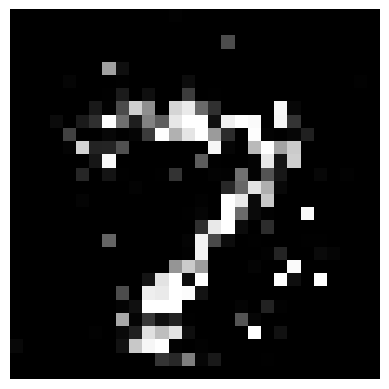

In [100]:
# load GAN models
generator.load_state_dict(torch.load('./GAN_models/generator.pth'))

# generate new images
with torch.no_grad():
    # random noise
    noise = torch.randn(1, latent_dim).to(device)
    # use generator to generate image
    fake_image = generator(noise).reshape(28, 28)
    # show generated image
    plt.imshow(fake_image.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

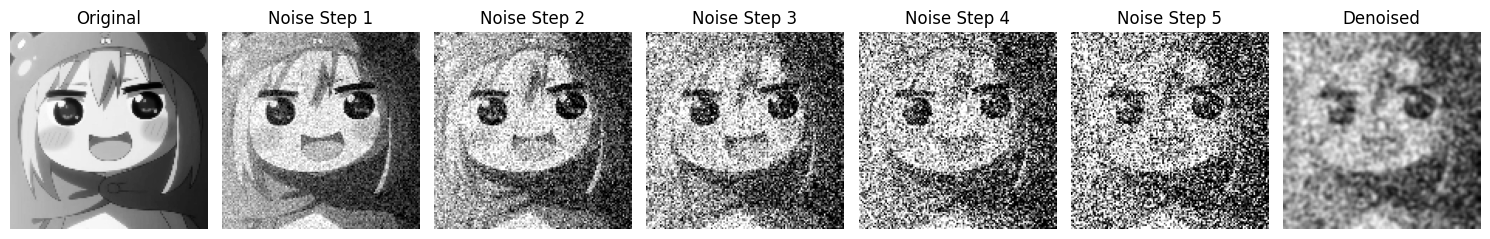


Noise Levels:
Step 1: 0.0968
Step 2: 0.1777
Step 3: 0.2453
Step 4: 0.3024
Step 5: 0.3460

Noise Reduction:
Before denoising: 0.3460
After denoising: 0.1479
Reduction: 57.26%


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def add_and_denoise():
    # Load and preprocess the image
    image = cv2.imread('Cute.jpg', cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128)) / 255.0  # Normalize to range [0, 1]

    # Create figure for visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 7, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Add Gaussian noise in steps
    noisy_images = []
    for i in range(5):  # 5 noise addition steps
        noise = np.random.normal(0, 0.1 * (i + 1), image.shape)  # Increase noise level
        noisy_image = np.clip(image + noise, 0, 1)  # Ensure values are within [0, 1]
        noisy_images.append(noisy_image)
        
        # Display noisy image
        plt.subplot(1, 7, i + 2)
        plt.imshow(noisy_image, cmap='gray')
        plt.title(f'Noise Step {i+1}')
        plt.axis('off')

    # Denoising using GaussianBlur
    denoised_image = cv2.GaussianBlur(noisy_images[-1], (5, 5), 0)
    plt.subplot(1, 7, 7)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print noise levels
    print("\nNoise Levels:")
    for i in range(5):
        noise_level = np.std(noisy_images[i] - image)
        print(f"Step {i+1}: {noise_level:.4f}")

    # Print denoising effect
    original_noise = np.std(noisy_images[-1] - image)
    final_noise = np.std(denoised_image - image)
    print(f"\nNoise Reduction:")
    print(f"Before denoising: {original_noise:.4f}")
    print(f"After denoising: {final_noise:.4f}")
    print(f"Reduction: {((original_noise - final_noise)/original_noise)*100:.2f}%")

if __name__ == "__main__":
    add_and_denoise()

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

class SimpleMLP(nn.Module):
    """Simple MLP for noise prediction"""
    def __init__(self, input_dim=784):  # 28*28 = 784
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, 512),  # +1 for time embedding
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
        
    def forward(self, x, t):
        # Flatten image
        x = x.view(x.shape[0], -1)
        # Add time embedding
        t = t.view(-1, 1)
        x_t = torch.cat([x, t], dim=1)
        # Predict noise
        return self.net(x_t).view(x.shape[0], 1, 28, 28)

class FastMLPDiffusion:
    def __init__(self, timesteps=50):  # Even fewer timesteps
        self.timesteps = timesteps
        
        # Noise schedule
        self.betas = torch.linspace(1e-4, 0.02, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.model = SimpleMLP()
    
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        alpha_cumprod_t = self.alphas_cumprod[t]
        
        noisy_image = torch.sqrt(alpha_cumprod_t)[:, None, None, None] * x0 + \
                      torch.sqrt(1 - alpha_cumprod_t)[:, None, None, None] * noise
        return noisy_image, noise
    
    def sample(self, shape, device):
        x = torch.randn(shape).to(device)
        
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.tensor([t], device=device).float() / self.timesteps
            t_tensor = t_tensor.repeat(shape[0])
            
            predicted_noise = self.model(x, t_tensor)
            
            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]
            beta_t = self.betas[t]
            
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0
                
            x = (1 / torch.sqrt(alpha_t)) * (
                x - (beta_t / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise
            ) + torch.sqrt(beta_t) * noise
            
        return x

def train_mlp_diffusion(epochs=5, batch_size=512, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Train the MLP diffusion model"""
    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Initialize model
    diffusion = FastMLPDiffusion()
    diffusion.model.to(device)
    optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=2e-3)  # Increased learning rate
    
    # Training loop
    for epoch in range(epochs):
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch, _ in progress_bar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            t = torch.randint(0, diffusion.timesteps, (batch.shape[0],), device=device)
            noisy_image, noise = diffusion.forward_diffusion(batch, t)
            predicted_noise = diffusion.model(noisy_image, t.float() / diffusion.timesteps)
            
            loss = F.mse_loss(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix(loss=f'{loss.item():.4f}')
        
        # Generate samples at the end of each epoch
        if (epoch + 1) % 1 == 0:  # Generate every epoch
            diffusion.model.eval()
            with torch.no_grad():
                samples = diffusion.sample((16, 1, 28, 28), device)
                samples = (samples + 1) / 2
                
                plt.figure(figsize=(10, 10))
                for i in range(16):
                    plt.subplot(4, 4, i+1)
                    plt.imshow(samples[i, 0].cpu(), cmap='gray')
                    plt.axis('off')
                plt.savefig(f'./diffusion/mlp_samples_epoch_{epoch+1}.png')
                plt.close()
            diffusion.model.train()
    
    return diffusion

if __name__ == "__main__":
    model = train_mlp_diffusion(epochs=5)
    torch.save(model.model.state_dict(), './diffusion_models/fast_mlp_diffusion.pth')

Epoch 5/5: 100%|██████████| 118/118 [00:14<00:00,  8.41it/s, loss=0.9966]
